<a href="https://colab.research.google.com/github/Thamindu17/BTC/blob/main/btc_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Preparing metadata (setup.py) ... done


/tmp/ipython-input-1-3542235697.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc_df = yf.download("BTC-USD", period="730d", interval="1h")
[*********************100%***********************]  1 of 1 completed


Adding technical indicators...
DataFrame with features:
Price                              Close           High            Low  \
Ticker                           BTC-USD        BTC-USD        BTC-USD   
Datetime                                                                 
2025-07-29 14:00:00+00:00  117777.812500  118615.132812  117747.421875   
2025-07-29 15:00:00+00:00  117416.234375  117924.406250  117303.164062   
2025-07-29 16:00:00+00:00  117675.148438  117707.398438  117028.968750   
2025-07-29 17:00:00+00:00  117772.664062  118033.851562  117669.609375   
2025-07-29 18:00:00+00:00  117516.734375  117794.687500  117491.570312   

Price                               Open      Volume         ATR        RSI  \
Ticker                           BTC-USD     BTC-USD                          
Datetime                                                                      
2025-07-29 14:00:00+00:00  118615.132812           0  455.842151  39.462574   
2025-07-29 15:00:00+00:00  117821.2

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 72, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 72, 100)   │     42,800 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 72, 100)   │          1 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 72, 100)   │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 100)       │     80,400 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100)       │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 50)        │      5,050 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 48)        │      2,448 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 130,699 (510.54 KB)

 Trainable params: 130,699 (510.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 73s 140ms/step - loss: 0.0329 - val_loss: 6.2762e-04
Epoch 2/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 78s 131ms/step - loss: 0.0014 - val_loss: 5.8918e-04
Epoch 3/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 83s 134ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 4/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 81s 133ms/step - loss: 9.3835e-04 - val_loss: 5.4354e-04
Epoch 5/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 64s 130ms/step - loss: 7.4044e-04 - val_loss: 8.3283e-04
Epoch 6/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 84s 135ms/step - loss: 6.7269e-04 - val_loss: 6.1155e-04
Epoch 7/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 65s 133ms/step - loss: 6.8934e-04 - val_loss: 0.0022
Epoch 8/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 81s 131ms/step - loss: 6.8014e-04 - val_loss: 4.0991e-04
Epoch 9/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 65s 133ms/step - loss: 6.1038e-04 - val_loss: 8.1198e-04
Epoch 10/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 62s 128ms/step - loss: 6.6719e-04 - val_loss: 0.0011
Epoch 11/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 6

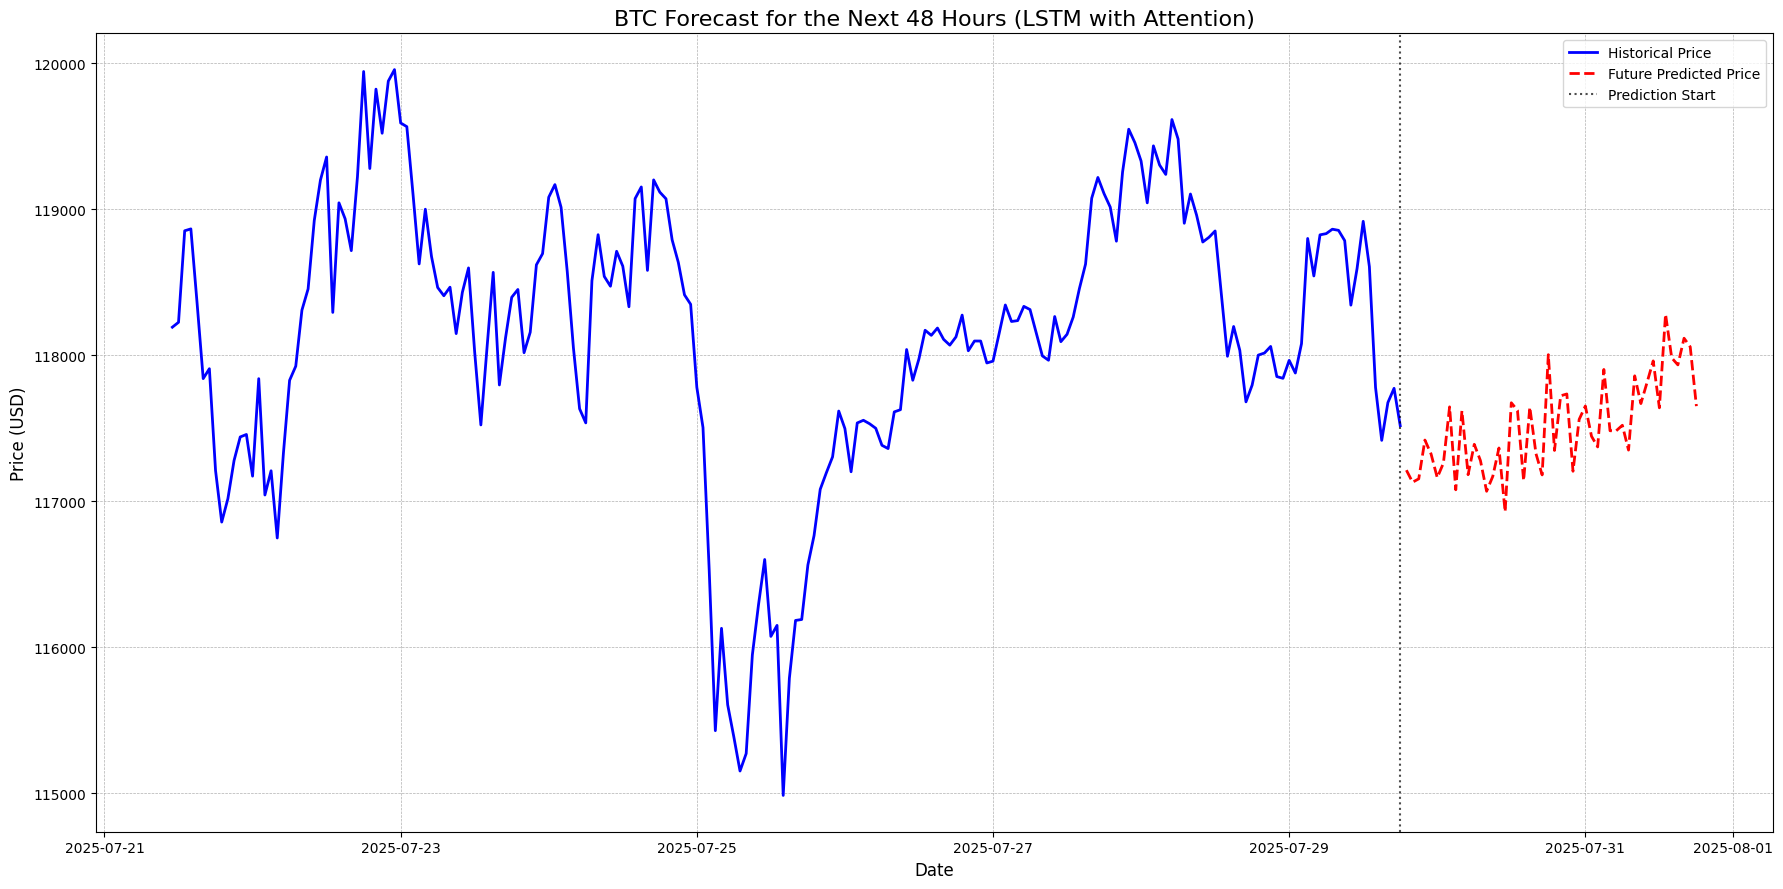


=== PREDICTION SUMMARY ===
Current BTC Price: $117,516.73
Predicted Price in 24 hours: $118,003.21 (+0.41%)
Predicted Price in 48 hours: $117,650.60 (+0.11%)
Prediction range: $116,926.67 - $118,280.26


In [1]:
# --- 0. INSTALL AND IMPORT LIBRARIES ---
!pip install yfinance ta tensorflow scikit-learn matplotlib -q

import yfinance as yf
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention
import tensorflow as tf
import matplotlib.pyplot as plt

# --- 1. DOWNLOAD DATA AND ENHANCED FEATURE ENGINEERING ---
# Download a larger dataset for more robust training
btc_df = yf.download("BTC-USD", period="730d", interval="1h")

# Add a richer set of technical indicators
print("Adding technical indicators...")
# Volatility
btc_df['ATR'] = ta.volatility.average_true_range(btc_df['High'].squeeze(), btc_df['Low'].squeeze(), btc_df['Close'].squeeze(), window=14)
# Momentum
btc_df['RSI'] = ta.momentum.rsi(btc_df['Close'].squeeze(), window=14)
btc_df['Stochastic_Oscillator'] = ta.momentum.stoch(btc_df['High'].squeeze(), btc_df['Low'].squeeze(), btc_df['Close'].squeeze(), window=14)
# Trend
btc_df['MACD_diff'] = ta.trend.macd_diff(btc_df['Close'].squeeze(), window_slow=26, window_fast=12, window_sign=9)
btc_df['ADX'] = ta.trend.adx(btc_df['High'].squeeze(), btc_df['Low'].squeeze(), btc_df['Close'].squeeze(), window=14)

# Drop rows with NaN values created by the indicators
btc_df = btc_df.dropna()
print("DataFrame with features:")
print(btc_df.tail())


# --- 2. ADVANCED DATA PREPARATION AND SCALING (CORRECTED) ---
# Define the target and features
target_col = 'Close'
# CORRECTED: Fixed the typo "Stochastic__Oscillator" to "Stochastic_Oscillator"
feature_cols = ['ATR', 'RSI', 'Stochastic_Oscillator', 'MACD_diff', 'ADX']

# Scale the target and features separately for better model performance
target_scaler = MinMaxScaler()
feature_scaler = MinMaxScaler()

# Fit and transform the data
scaled_target = target_scaler.fit_transform(btc_df[[target_col]])
scaled_features = feature_scaler.fit_transform(btc_df[feature_cols])

# Combine scaled data for sequence creation
combined_scaled_data = np.concatenate([scaled_target, scaled_features], axis=1)

# Constants for the sequences
SEQ_LEN = 72      # Use 72 hours (3 days) of history
N_FUTURE = 48     # Predict the next 48 hours

def create_sequences(data, seq_length, n_future):
    X, y = [], []
    for i in range(len(data) - seq_length - n_future + 1):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length : i + seq_length + n_future, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(combined_scaled_data, SEQ_LEN, N_FUTURE)

# Split the data into training and testing sets
split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# --- 3. BUILD AND TRAIN THE LSTM WITH ATTENTION MODEL ---
print("\nBuilding and training the corrected LSTM with Attention model...")

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_out_1 = LSTM(units=100, return_sequences=True)(input_layer)
attention_out = Attention(use_scale=True)([lstm_out_1, lstm_out_1])
attention_out = Dropout(0.2)(attention_out)
lstm_out_2 = LSTM(units=100, return_sequences=False)(attention_out)
lstm_out_2 = Dropout(0.2)(lstm_out_2)
dense_1 = Dense(units=50, activation='relu')(lstm_out_2)
output_layer = Dense(units=N_FUTURE)(dense_1)
model = Model(inputs=input_layer, outputs=output_layer)

stable_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=stable_optimizer, loss='mean_squared_error')
model.summary()

# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping], verbose=1)


# --- 4. FORECAST THE FUTURE AND VISUALIZE ---
last_sequence = combined_scaled_data[-SEQ_LEN:]
last_sequence_reshaped = np.reshape(last_sequence, (1, SEQ_LEN, combined_scaled_data.shape[1]))

predicted_future_scaled = model.predict(last_sequence_reshaped)[0]
future_predictions = target_scaler.inverse_transform(predicted_future_scaled.reshape(-1, 1)).flatten()

print("\nGenerating forecast plot...")
future_timestamps = pd.date_range(start=btc_df.index[-1], periods=N_FUTURE + 1, freq='h')[1:]
historical_prices_for_plot = btc_df[target_col].iloc[-200:]

plt.figure(figsize=(18, 9))
plt.plot(historical_prices_for_plot.index, historical_prices_for_plot.values, label='Historical Price', color='blue', linewidth=2)
plt.plot(future_timestamps, future_predictions, label='Future Predicted Price', color='red', linestyle='--', linewidth=2)
plt.axvline(x=btc_df.index[-1], color='black', linestyle=':', alpha=0.7, label='Prediction Start')
plt.title(f'BTC Forecast for the Next {N_FUTURE} Hours (LSTM with Attention)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


# --- 5. PRINT PREDICTION SUMMARY ---
current_price = btc_df[target_col].iloc[-1].item()
price_24h = future_predictions[23]
price_48h = future_predictions[47]

print("\n=== PREDICTION SUMMARY ===")
print(f"Current BTC Price: ${current_price:,.2f}")
print(f"Predicted Price in 24 hours: ${price_24h:,.2f} ({((price_24h - current_price) / current_price * 100):+.2f}%)")
print(f"Predicted Price in 48 hours: ${price_48h:,.2f} ({((price_48h - current_price) / current_price * 100):+.2f}%)")
print(f"Prediction range: ${np.min(future_predictions):,.2f} - ${np.max(future_predictions):,.2f}")